# Modelamiento
## 1. División y Escalamiento
* **NO Aleatoriedad (No Shuffle):** No puedes usar train_test_split aleatorio. No se puede predecir el clima de ayer usando datos de mañana. Debemos cortar el tiempo cronológica y secuencialmente.

* **Fuga de Datos (Data Leakage) en el Escalado:** El escalador (StandardScaler) debe aprender (fit) SOLO con los datos de entrenamiento y luego aplicarse al test, no al revés.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os

In [16]:
# Carga de datos
df_clean = pd.read_csv('../../data/processed/df_clean.csv', index_col='time')
df_clean.index = pd.to_datetime(df_clean.index)

In [17]:
# 1. Selección de Features (Variables Predictoras)
# Incluimos 'HR' aunque tenga baja correlación lineal por la capacidad de 
# las redes neuronales para capturar relaciones no lineales.
features = ['radinf', 'HR', 'pp', 'press', 'vel', 'dir_sin', 'dir_cos']
target = 'tempsup'

X = df_clean[features]
y = df_clean[target]

In [18]:
# 2. División Temporal (Time Series Split)
# shuffle=False es IMPORTANTE aquí para evitar mezclar datos futuros con pasados.
# Usaremos los últimos datos como test para simular el futuro.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("--- Dimensiones del Dataset ---")
print(f"Train (Entrenamiento): {X_train.shape[0]} horas ({X_train.index.min().date()} al {X_train.index.max().date()})")
print(f"Test (Prueba):         {X_test.shape[0]} horas ({X_test.index.min().date()} al {X_test.index.max().date()})")

--- Dimensiones del Dataset ---
Train (Entrenamiento): 53760 horas (2018-01-01 al 2024-02-18)
Test (Prueba):         13440 horas (2024-02-19 al 2025-08-31)


In [19]:
# 3. Estandarización (StandardScaler)
scaler = StandardScaler()

# Fit solo en Train, Transform en ambos
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Recuperamos el formato DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

print("\n Datos procesados y escalados correctamente.")


 Datos procesados y escalados correctamente.


## 2. Modelo Base v1.0.0

### 2.1 Periodo 24 horas

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# 1. Inicializar y Entrenar
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [22]:
# 2. Predecir el Futuro (Test)
y_pred_lr = model_lr.predict(X_test_scaled)

In [23]:
# 3. Evaluar Rendimiento
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)

print(f"--- Resultados Línea Base (Linear Regression) ---")
print(f"MAE (Error Absoluto Medio): {mae:.2f} °C")
print(f"RMSE (Raíz Error Cuadrático): {rmse:.2f} °C")
print(f"R² (Varianza Explicada):      {r2:.4f}")

--- Resultados Línea Base (Linear Regression) ---
MAE (Error Absoluto Medio): 5.77 °C
RMSE (Raíz Error Cuadrático): 8.09 °C
R² (Varianza Explicada):      0.5364


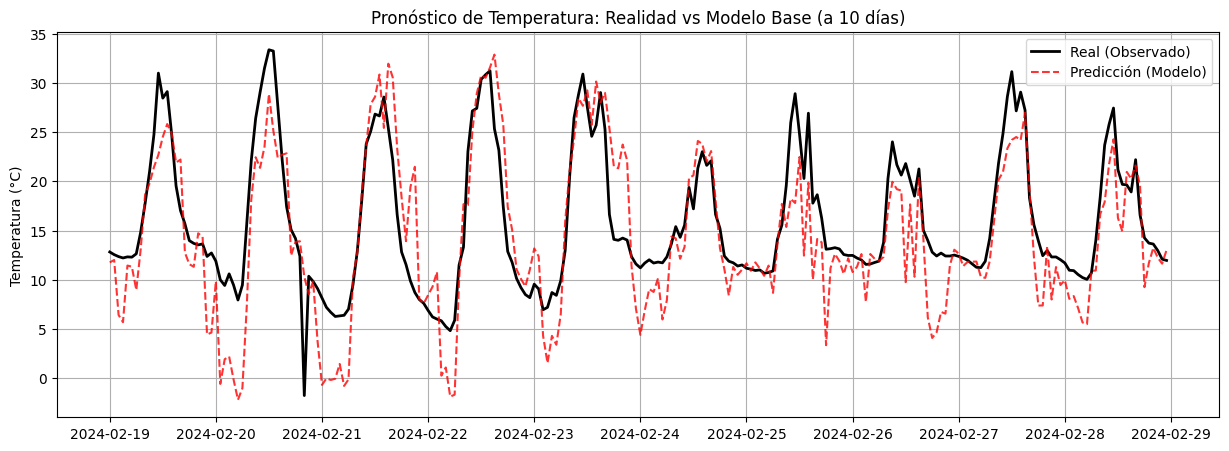

In [24]:
# 4. Visualización: Realidad vs Predicción (a 10 días)
# Graficamos solo los primeros 240 registros (10 días) para ver el detalle
plt.figure(figsize=(15, 5))
plt.plot(y_test.index[:240], y_test.iloc[:240], label='Real (Observado)', color='black', linewidth=2)
plt.plot(y_test.index[:240], y_pred_lr[:240], label='Predicción (Modelo)', color='red', linestyle='--', alpha=0.8)
plt.title("Pronóstico de Temperatura: Realidad vs Modelo Base (a 10 días)")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.grid(True)
plt.show()

### 2.2 Periodo Nocturno (18:00 - 7:00)

In [25]:
# 1. FILTRADO: Nos quedamos SOLO con el horario nocturno
# Usamos el dataset limpio, pero recortamos las horas
df_model_night = df_clean.between_time('18:00', '07:00').copy()

In [26]:
# 2. PREPARACIÓN (X e y)
features = ['radinf', 'HR', 'pp', 'press', 'vel', 'dir_sin', 'dir_cos']
target = 'tempsup'

X = df_model_night[features]
y = df_model_night[target]

In [27]:
# 3. SPLIT (Respetando el orden temporal)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [28]:
# 4. ESCALADO
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
# 5. ENTRENAMIENTO (Modelo Base - Solo Noche)
model_lr_night = LinearRegression()
model_lr_night.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [30]:
# 6. EVALUACIÓN
y_pred_night = model_lr_night.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred_night)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_night))
r2 = r2_score(y_test, y_pred_night)

print(f"--- Resultados Modelo Base (SOLO NOCHE) ---")
print(f"MAE:  {mae:.2f} °C")
print(f"RMSE: {rmse:.2f} °C")
print(f"R²:   {r2:.4f}")

--- Resultados Modelo Base (SOLO NOCHE) ---
MAE:  2.70 °C
RMSE: 5.30 °C
R²:   0.3045


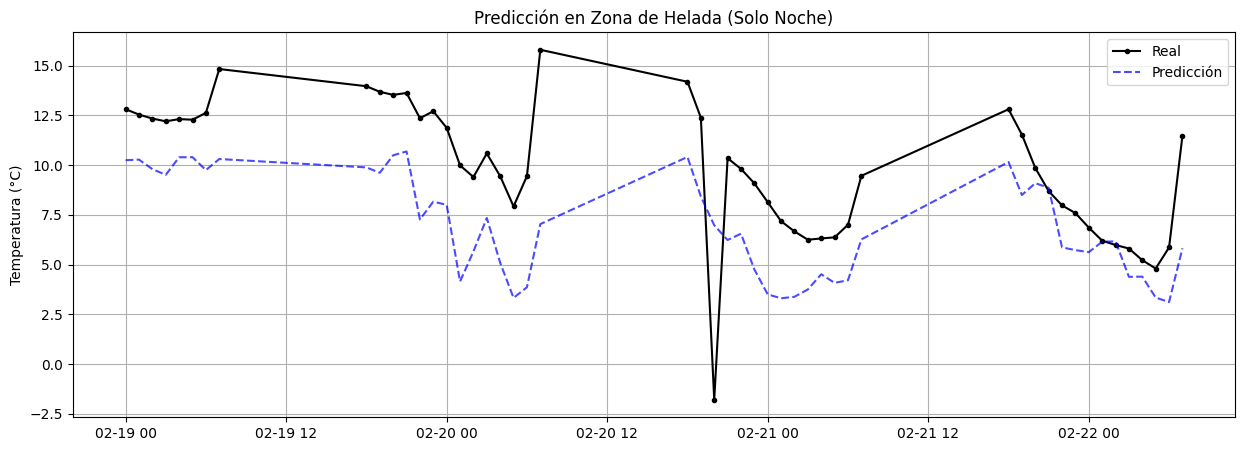

In [31]:
# 7. GRÁFICO (a 4 días, aprox 50 horas nocturnas)
plt.figure(figsize=(15, 5))
# Graficamos los primeros 50 puntos del test para ver el detalle
plt.plot(y_test.index[:50], y_test.iloc[:50], label='Real', color='black', marker='.')
plt.plot(y_test.index[:50], y_pred_night[:50], label='Predicción', color='blue', linestyle='--', alpha=0.7)
plt.title("Predicción en Zona de Helada (Solo Noche)")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.grid(True)
plt.show()

## 3. Modelo Base v1.1.0

### 3.1 Periodo Nocturno con Top Features (18:00 - 7:00)

In [32]:
# 1. Definimos las "Top Features" basadas en los análisis de correlación
# Quitamos 'press' (-0.18), 'pp' (0.05) y 'vel' (-0.01) que aportaban ruido
top_features = ['radinf', 'dir_sin', 'dir_cos', 'HR']
target = 'tempsup'

In [ ]:
# 2. Preparamos X e y con el subconjunto 'top features' seleccionado (SOLO NOCHE)
X_selected = df_model_night[top_features]
y_selected = df_model_night[target]

In [ ]:
# 3. Split Temporal
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, y_selected, test_size=0.2, shuffle=False)

In [35]:
# 4. Escalado
scaler_sel = StandardScaler()
X_train_sel_scaled = scaler_sel.fit_transform(X_train_sel)
X_test_sel_scaled = scaler_sel.transform(X_test_sel)

In [36]:
# 5. Entrenamiento V2
model_lr_v2 = LinearRegression()
model_lr_v2.fit(X_train_sel_scaled, y_train_sel)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [37]:
# 6. Evaluación
y_pred_v2 = model_lr_v2.predict(X_test_sel_scaled)

mae_v2 = mean_absolute_error(y_test_sel, y_pred_v2)
r2_v2 = r2_score(y_test_sel, y_pred_v2)

print(f"--- Comparativa: Todas las Variables vs Top Features ---")
print(f"MAE Original: 2.70 °C  ->  MAE Nuevo: {mae_v2:.2f} °C")
print(f"RMSE Original: 3.35 °C  ->  RMSE Nuevo: {np.sqrt(mean_squared_error(y_test_sel, y_pred_v2)):.2f} °C")
print(f"R² Original:  0.3045   ->  R² Nuevo:  {r2_v2:.4f}")

--- Comparativa: Todas las Variables vs Top Features ---
MAE Original: 2.70 °C  ->  MAE Nuevo: 2.74 °C
RMSE Original: 3.35 °C  ->  RMSE Nuevo: 5.35 °C
R² Original:  0.3045   ->  R² Nuevo:  0.2903


In [38]:
# 7. Coeficientes
coefs = pd.DataFrame(model_lr_v2.coef_, top_features, columns=['Peso (Coeficiente)'])
print("\n--- Peso de las Variables en la Ecuación ---")
print(coefs.sort_values(by='Peso (Coeficiente)', ascending=False))


--- Peso de las Variables en la Ecuación ---
         Peso (Coeficiente)
radinf             2.923067
dir_sin            0.358101
dir_cos           -0.315321
HR                -1.243003


## Conclusiones Modelos Base

Entrenamos un modelo base de Regresión Lineal con las siguientes características.

1. El modelamiento con todas las variables para un periodo de 24 horas:
* ['radinf', 'HR', 'pp', 'press', 'vel', 'dir_sin', 'dir_cos']

    1. Obtuvo los resultados:

    | Métrica                    |  Valor  |
    |----------------------------|---------|
    | MAE (Error Absoluto Medio) | 5.77 °C |
    | RMSE (Raíz Error Cuadrático): | 8.09 °C |
    | R² (Varianza Explicada): | 0.5364 |

2. El modelamiento con todas las variables para el periodo nocturno (18:00 - 7:00):
* ['radinf', 'HR', 'pp', 'press', 'vel', 'dir_sin', 'dir_cos']

    2. Obtuvo unos resultados:

    | Métrica                    |  Valor  |
    |----------------------------|---------|
    | MAE (Error Absoluto Medio) | 2.70 °C |
    | RMSE (Raíz Error Cuadrático): | 5.30 °C |
    | R² (Varianza Explicada): | 0.3045 |

3. El modelamiento utilizando las **variables rankeadas** para el periodo nocturno (18:00 - 7:00):
* ['radinf', 'dir_sin', 'dir_cos', 'HR']

    3. Obtuvo los resultados:

    | Métrica                    |  Valor  |
    |----------------------------|---------|
    | MAE (Error Absoluto Medio) | 2.74 °C |
    | RMSE (Raíz Error Cuadrático): | 5.35 °C |
    | R² (Varianza Explicada): | 0.2903 |

Los datos muestran la no linealidad entre las variables.

**El Estancamiento:** Que el $R^2$ baje al quitar variables ruidosas y que el MAE empeore indica que el modelo lineal estaba ajustando los datos a una recta de manera imprecisa.

**Los Coeficientes:** radinf tiene un peso alto (2.92). Esto captura las relaciones simples, pero no las relaciones complejas:

* P.ej.:

    Si $radinf > 200 W/m^2$ -> calor

    Pero Si 
    $radinf < 200 W/m^2$ y $HR < 50%$ -> ?


## 4. Random Forest Regressor
### 4.1 Periodo 24 horas

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
# 1. Configuración del Modelo
# n_estimators=100: Creará 100 árboles (estándar robusto)
# n_jobs=-1: Usa todos los núcleos de tu CPU para ir rápido
# random_state=42: Para que tus resultados sean reproducibles
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("Entrenando Random Forest...")
# Usamos X_train_scaled (con todas las variables) para dejar que el RF decida qué importa
rf_model.fit(X_train_scaled, y_train)

Entrenando Random Forest...


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [42]:
# 2. Predicción
y_pred_rf = rf_model.predict(X_test_scaled)

In [ ]:
# 3. Evaluación
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\n--- Resultados RANDOM FOREST (NOCHE) ---")
print(f"MAE:  {mae_rf:.2f} °C")
print(f"RMSE: {rmse_rf:.2f} °C")
print(f"R²:   {r2_rf:.4f}")


--- Resultados RANDOM FOREST (24 horas) ---
MAE:  2.84 °C
RMSE: 5.81 °C
R²:   0.1656


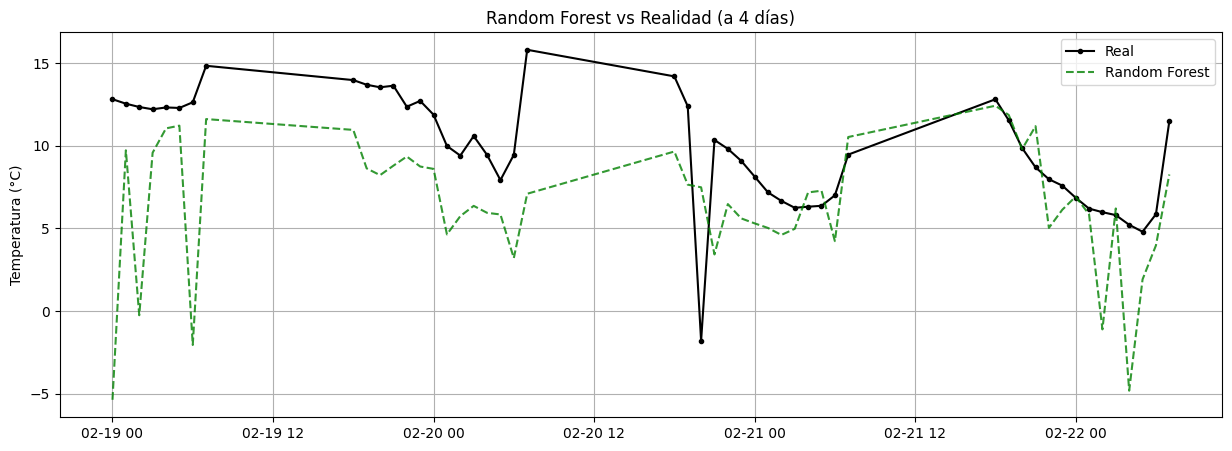

In [ ]:
# 4. Comparativa Visual (a 4 días)
plt.figure(figsize=(15, 5))
plt.plot(y_test.index[:50], y_test.iloc[:50], label='Real', color='black', marker='.')
# Línea Verde para el RF
plt.plot(y_test.index[:50], y_pred_rf[:50], label='Random Forest', color='green', linestyle='--', alpha=0.8)
plt.title("Random Forest vs Realidad (a 4 días)")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.grid(True)
plt.show()